C:\Users\HTM-I5\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
C:\Users\HTM-I5\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


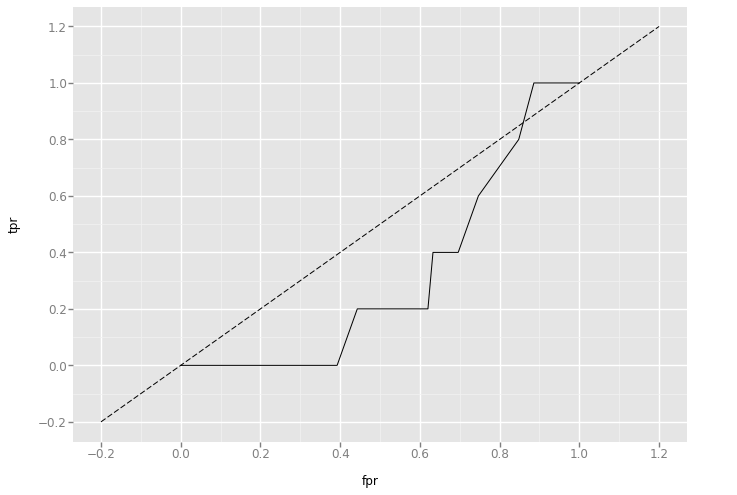

<ggplot: (-9223372019850112182)>

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyodbc
import xlsxwriter
from sklearn import metrics
from ggplot import *
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

# Parameters
server = 'localhost'
db = 'D4R_VOICE'

# Create the connection
conn = pyodbc.connect('DRIVER={SQL Server};SERVER=' + server + ';DATABASE=' + db + ';Trusted_Connection=yes')

# query db
#sql = """
#SELECT        TOP (50) PERCENT dbo.Table_gunler.tarih, CAST(dbo.View_BODRUM_Count_refugee_call_duration.adet AS INT) AS adet
#FROM            dbo.Table_gunler FULL OUTER JOIN
#                         dbo.View_BODRUM_Count_refugee_call_duration ON dbo.Table_gunler.tarih = dbo.View_BODRUM_Count_refugee_call_duration.tarih
#ORDER BY dbo.Table_gunler.tarih
#"""
sql= """
SELECT        TOP (100) PERCENT COUNT(dbo.[Dataset 1_Voice_RAW].REFUGEE_CALL_DURATION) AS adet, dbo.Events.event, dbo.[Dataset 1_Voice_RAW].date, SUM(dbo.[Dataset 1_Voice_RAW].REFUGEE_CALL_DURATION) 
                         AS toplam, SUM(dbo.[Dataset 1_Voice_RAW].REFUGEE_CALL_DURATION) / COUNT(dbo.[Dataset 1_Voice_RAW].REFUGEE_CALL_DURATION) AS deger
FROM            dbo.Base_Station_Location INNER JOIN
                         dbo.[Dataset 1_Voice_RAW] ON dbo.Base_Station_Location.BTS_ID = dbo.[Dataset 1_Voice_RAW].OUTGOING_SITE_ID FULL OUTER JOIN
                         dbo.Events ON dbo.[Dataset 1_Voice_RAW].date = dbo.Events.date AND dbo.Base_Station_Location.MX_SAHAIL = dbo.Events.city AND dbo.Base_Station_Location.MX_SILCE = dbo.Events.district
GROUP BY dbo.[Dataset 1_Voice_RAW].date, dbo.Base_Station_Location.MX_SAHAIL, dbo.Base_Station_Location.MX_SILCE, dbo.Events.event
HAVING        (dbo.Base_Station_Location.MX_SAHAIL = 'BALIKESIR') AND (dbo.Base_Station_Location.MX_SILCE = 'AYVALIK')
ORDER BY dbo.[Dataset 1_Voice_RAW].date
"""

df = pd.read_sql(sql, conn)

##########################
xtrainyetmis=df['deger'].fillna(method="pad").head(int(len(df)*0.7)) 
xtestotuz=df['deger'].fillna(method="pad").tail(int(len(df)*0.3))
ytrainyetmis=df['event'].fillna(value=0).head(int(len(df)*0.7)) 
ytestotuz=df['event'].fillna(value=0).tail(int(len(df)*0.3))

#########################
X, y = make_classification(n_samples=(int(len(df)*0.7))  + (int(len(df)*0.3)) , n_features=10, n_classes=2, n_informative=5)
Xtrain = xtrainyetmis.reshape(-1, 1)
Xtest = xtestotuz.reshape(-1, 1)
ytrain = ytrainyetmis
ytest = ytestotuz

clf = LinearRegression(normalize=True) #normalize=true best for datas
clf.fit(Xtrain, ytrain)

############################
preds = clf.predict(Xtest)
fpr, tpr, _ = metrics.roc_curve(ytest, preds)

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', y='tpr')) +\
 geom_line() +\
 geom_abline(linetype='dashed')